In [1]:
#LESJ_知財に関する統合報告書大賞_企業別形態素解析出力
# テキストをリスト単位で取り込み、リスト単位で形態素解析
import pandas as pd
import MeCab
import fitz
import re
import sys
sys.path.append('/work_dir') 
import talknize_module_20240909 as tk
import csv


In [2]:
#形態素解析の前処理
#分析対象データの特性に対応するため、前処理はモジュールではなくコードとして記載
#talknize_module.pyにも標準的な処理も記載し、適宜使い分け可能にする

#----------------------------------------------------------------------
#テキストファイルの各行に記載された文字列を、処理用文字列として整形・リスト化
def text_to_list(file_path):

    # 空のリストを作成
    return_list = []
    try:
        # 指定されたファイルを読み込み、各行をリストに追加
        with open(file_path, 'r') as file:
            # ファイル内の各行をループし、行末の改行や余分な空白を除去してリストに格納
            return_list = [line.strip() for line in file]
    # ファイルが存在しない場合は例外を無視する
    except FileNotFoundError:
        pass
    # リストを返す
    return return_list

#----------------------------------------------------------------------
#形態素解析前のテキストデータ処理（
#形態素解析の前に、無駄な記号やヘッダ・フッタ等の文言をテキストから除外
def pre_tk(text, excl_list):

    replaced_text = text

    #exclusion_list処理前に処理する必要のあるもの
    #【特例処理】除外処理前に、文頭のこれら記号は「箇条書き」とみなし、続く文言を一文として扱う
    replaced_text = re.sub(r'[■□▪▫▲△▶▷▸▹▼▽◆◇●〇]', '。\n', replaced_text)
    #replaced_text = re.sub(r'[〇●◇◆□■▶△▲▽▼▫▪▹▶▸]', '', replaced_text)#上記以外は除去

    exclusion_list = []    
    exclusion_file1 = "userdic/exclusion_phrases1.txt"  # 各企業の除外フレーズを記載したリスト
    exclusion_file2 = "userdic/exclusion_codes.txt"  # その他記号・年月日・URL等を除外するためのリスト
    #exclusion_file3 = "userdic/exclusion_phrases2.txt"  # 各企業の除外フレーズを記載したリスト2（pageinfoから都度取り込み）
#    exclusion_list = text_to_list(exclusion_file1) + text_to_list(exclusion_file2)+ text_to_list(exclusion_file3)
    exclusion_list = excl_list + text_to_list(exclusion_file1) + text_to_list(exclusion_file2)

    for pattern in exclusion_list:
        replaced_text = re.sub(pattern, ' ', replaced_text)

    return replaced_text


In [3]:
#形態素解析の後処理
#形態素解析結果（tokenリスト）から、ストップワード、特定の条件の文字列等を除外
#import fitz
#import re
from collections import OrderedDict
import re

def post_tk(tokens):
    
    replaced_list = tokens    

    # stopwords（ファイルに格納）を除去
    path_stopwords = "userdic/stopwords.txt"
    stopwords = text_to_list(path_stopwords)
    stopwords = list(OrderedDict.fromkeys(stopwords)) # 元の順序を保持しつつ、重複を除去（# Python 3.7以降）
    replaced_list = [t for t in replaced_list if t not in stopwords]
    
    # ひらがなのみの要素を除去
    kana_re = re.compile("^[ぁ-ゖ]+$")
    replaced_list = [t for t in replaced_list if not kana_re.match(t)]

    # アルファベット1文字のみの要素を除去
    alphabet_re = re.compile("^[a-zA-Z]$")
    replaced_list = [t for t in replaced_list if not alphabet_re.match(t)]

    #特定の形態の数値要素を除去
    number_re = re.compile("^[\d,]+")
    replaced_list = [t for t in replaced_list if not number_re.match(t)]

    
    return replaced_list

In [4]:
#評価対象企業の情報を取り込み
#対象を格納したファイルを指定
target_file="data/lesj_target.csv"

#データ形式を指定
dtype_spec = {
    '市場': 'str',  #市場
    '業種': 'str',  #業種
    'コード': 'int32',  #コード
    '銘柄名': 'str',  # 銘柄名
    'file_name': 'str'  # file_name
}

df_targets= pd.read_csv(target_file, dtype=dtype_spec)
#print(df_targets.dtypes)
#df_targets.head()

In [5]:
# CSVファイルのパス
csv_file_path = 'data/page_info.csv'

dtype_pageinfo = {
    '市場': 'str',  
    '業種': 'str',  
    'コード': 'int64',  
    '銘柄名': 'str',  
    'file_name': 'str',  
    'ページ範囲1': 'str', 
    'ページ範囲2': 'str', 
    'ページ範囲3': 'str', 
    '除外文字列': 'str'
}
df_pageinfo = pd.read_csv(csv_file_path, dtype=dtype_pageinfo, encoding='utf-8-sig', na_filter=False)

# フィールドをリストに分割して数値に変換し、アンダースコアを除外する関数
def convert_to_list(cell):
    return [int(x) for x in cell.strip('"').split(',') if x != '-' and x.strip() != '']

# 範囲をリストに変換
df_pageinfo['ページ範囲1'] = df_pageinfo.iloc[:, 5].apply(convert_to_list)
df_pageinfo['ページ範囲2'] = df_pageinfo.iloc[:, 6].apply(convert_to_list)
df_pageinfo['ページ範囲3'] = df_pageinfo.iloc[:, 7].apply(convert_to_list)


In [6]:
#-------------------
#分析対象企業をセキュリティコードで指定
#-------------------
#security_code=20020 #日清製粉グループ本社
#security_code=25010 #サッポロホールディングス
#security_code=25030 #キリンホールディングス
#security_code=26070 #不二製油グループ本社
#security_code=28020 #味の素
#security_code=29140 #日本たばこ産業
#security_code=31010 #東洋紡
#security_code=34010 #帝人
#security_code=34070 #旭化成
#security_code=40050 #住友化学
#security_code=40210 #日産化学
#security_code=40230 #クレハ #利用不可
#security_code=40280 #石原産業
#security_code=40420 #東ソー
#security_code=40630 #信越化学工業
#security_code=41140 #日本触媒
#security_code=42020 #ダイセル
#security_code=42030 #住友ベークライト
#security_code=42050 #日本ゼオン
#security_code=44520 #花王
#security_code=44610 #第一工業製薬
#security_code=46120 #日本ペイントホールディングス
#security_code=46310 #ＤＩＣ
#security_code=49110 #資生堂
#security_code=49120 #ライオン
#security_code=49220 #コーセー
#security_code=49270 #ポーラ・オルビスホールディングス
#security_code=49960 #クミアイ化学工業
#security_code=41510 #協和キリン
#security_code=45020 #武田薬品工業
#security_code=45030 #アステラス製薬
#security_code=45060 #住友ファーマ
#security_code=45190 #中外製薬
#security_code=45210 #科研製薬
#security_code=45230 #エーザイ
#security_code=45270 #ロート製薬
#security_code=45280 #小野薬品工業
#security_code=45300 #久光製薬
#security_code=45340 #持田製薬
#security_code=45360 #参天製薬
#security_code=45470 #キッセイ薬品工業
#security_code=45680 #第一三共
#security_code=45690 #杏林製薬
#security_code=45780 #大塚ホールディングス
#security_code=50200 #ＥＮＥＯＳホールディングス
#security_code=51010 #横浜ゴム
#security_code=52320 #住友大阪セメント
#security_code=53100 #東洋炭素
#security_code=53330 #日本碍子
#security_code=53340 #日本特殊陶業
#security_code=54010 #日本製鉄
#security_code=54060 #神戸製鋼所
#security_code=57110 #三菱マテリアル
#security_code=57270 #東邦チタニウム
#security_code=58020 #住友電気工業
#security_code=63320 #月島ホールディングス
#security_code=63610 #荏原製作所
#security_code=63670 #ダイキン工業
#security_code=63700 #栗田工業
#security_code=64900 #日本ピラー工業
#security_code=70110 #三菱重工業
#security_code=70130 #ＩＨＩ
#security_code=64480 #ブラザー工業
#security_code=65010 #日立製作所
#security_code=65250 #ＫＯＫＵＳＡＩ_ＥＬＥＣＴＲＩＣ
#security_code=66450 #オムロン
#security_code=66740 #ジーエス・ユアサ_コーポレーション
#security_code=67010 #日本電気
#security_code=67020 #富士通
#security_code=67270 #ワコム
#security_code=67520 #パナソニック_ホールディングス
#security_code=67530 #シャープ
#security_code=67580 #ソニーグループ
#security_code=67620 #ＴＤＫ
#security_code=68100 #マクセル
#security_code=68410 #横河電機
#security_code=68560 #堀場製作所
#security_code=69520 #カシオ計算機
#security_code=69630 #ローム
#security_code=69760 #太陽誘電
#security_code=72760 #小糸製作所
#security_code=77350 #ＳＣＲＥＥＮホールディングス
#security_code=77510 #キヤノン
#security_code=77520 #リコー
#security_code=70120 #川崎重工業
#security_code=72030 #トヨタ自動車
#security_code=72590 #アイシン
#security_code=72670 #本田技研工業
#security_code=72700 #ＳＵＢＡＲＵ
#security_code=45430 #テルモ
#security_code=63760 #日機装
#security_code=77470 #朝日インテック
#security_code=77800 #メニコン
#security_code=79110 #ＴＯＰＰＡＮホールディングス
#security_code=79150 #ＮＩＳＳＨＡ
#security_code=79360 #アシックス
#security_code=79510 #ヤマハ
security_code=69020 #デンソー
#-------------------
#分析対象範囲を指定
#-------------------
#analysis_area='Management'
analysis_area='Value'
#analysis_area='IP'
#-------------------

In [7]:
# セキュリティコードに基づいてフィルタリング
matching_rows = df_targets[df_targets['コード'] == security_code]

#print(matching_rows)

if not matching_rows.empty:
    row = matching_rows.iloc[0]  # 最初の行を選択:行をilocを使って明示的に選択
    industry = row['業種']
    company_name = row['銘柄名']
    company_code = row['コード']
    doc_name = row['file_name']
#print(df_pageinfo['コード'] )

matching_pageinfo_rows=df_pageinfo[df_pageinfo['コード'] ==security_code]
#print(matching_pageinfo_rows)

#除外文字列のテキストファイルを定義（tokenized関数処理時に読み込み）
output_file_path = 'userdic/exclusion_phrases2.txt'

# 初期化
page_area1 = ''
page_area2 = ''
page_area3 = ''
eliminate_phrases = []

if not matching_pageinfo_rows.empty:
    row_pageinfo = matching_pageinfo_rows.iloc[0] 
    conpany_name_pageinfo = row_pageinfo['銘柄名']
    page_area1 = row_pageinfo['ページ範囲1']
    page_area2 = row_pageinfo['ページ範囲2']
    page_area3 = row_pageinfo['ページ範囲3']
    eliminate_phrases = row_pageinfo['除外文字列']
    #除外文字列をリストに格納、pre_TK()の引数に使う
    eliminate_list = eliminate_phrases.split('\n')
    #print(row_pageinfo)
    #print(eliminate_phrases)
    #print(eliminate_list)

if analysis_area == 'IP':
    man_page_index = page_area3
elif analysis_area == 'Value':
    man_page_index = page_area2
else:
    man_page_index = page_area1
    
print(security_code)
print(company_name)
print(analysis_area)

# man_page_indexが空の場合はここでプログラム終了
if len(man_page_index) == 0:
    sys.exit()


69020
デンソー
Value


In [8]:
#PDFファイルを開き、ページ単位でテキストデータを取得

open_file='ir/'+ str(security_code) + '_' + company_name + '/' + doc_name
doc = fitz.open(open_file) 

#ページ単位でテキストをリストに格納
#page_textにはインデックスは付与されていない
page_text=[]
for page in doc:
    text = page.get_text() # プレーンテキストを取得
    #if text != '' :
        #無駄な改行を削除の上で'。'で改行、一文の範囲を明確にする
    text = re.sub(r'。','。\n', re.sub(r'\n','', text))
        #リストに格納
    page_text.append(text)

In [9]:
#print(page_text)

In [10]:
#len(page_text)

In [11]:
chk_flag=0
if chk_flag==1:
    for i in range(len(page_text)):
        print(i)
        print(page_text[i])
        print('---------------------------')

In [12]:
#ページテキストチェック用
#chk_flag=1の場合に取り込んだデータを表示
chk_flag=0
n=5
span=7
if chk_flag==1:
    for repeat in range(span):
        print(page_text[n+repeat])
        print()

In [13]:
#page_text内の一部のトピックのみを対象としたいときに利用
#生のリストデータを表示し、必要な範囲をコピー、次のセクションで貼り付け
#i=96
#page_text[i]

In [14]:
#page_text[i]の内容を書き換え
#page_text[i]='96Integrated Report トップメッセージ価値創造の源流̶トヨタらしさ価値創造のストーリー̶クルマ屋が描く未来のモビリティ社会価値創造の経営基盤コーポレートデータ CSOメッセージ   社外取締役座談会   株主・投資家との対話   コーポレートガバナンス   CFOメッセージ 資本戦略   環境   サーキュラーエコノミー   人材育成   ダイバーシティ、エクイティ＆インクルージョン   健康・安全衛生、社会貢献   人権の尊重   バリューチェーン連携   車両安全   品質、情報セキュリティ   知的財産、プライバシー知的財産基本的な考え方\u3000トヨタは、他に先んじた研究開発に挑戦し続けることで商品力と技術力を高め、それを競争力の源泉としてきました。\nそうした研究開発によって生み出された製品の根幹には、発明やノウハウ、ブランドなどの知的財産が必ず存在し、トヨタの重要な経営資源となっています。\nこれらの知的財産を適切に保護・活用し、社会に貢献していきます。\n知的財産活動\u3000トヨタは未来のモビリティ社会の実現に向け、経営施策と連動した知的財産活動を実施しています。\n例えば、電動車や電池の開発をはじめとする「カーボンニュートラル」やコネクティッド技術、自動運転技術に係る「ソフトウェアとコネクティッド」の領域へ重点的にリソーセスを振り分け、知的財産権の取得・活用を強化し、将来の競争力強化に努めています。\n推進体制\u3000日本、米国、欧州、中国の研究開発拠点に知的財産機能を設け、研究開発活動と知的財産活動を有機的・組織的に連携させ、グローバルに技術開発をサポートしています。\n世界各国で約110の有力な法律事務所と連携し、知的財産情報の収集や各国・各地域で生じる知財紛争にも適切に対処しています。\n\u3000また、経営、研究開発、知的財産の三位一体の活動を推進するため「知的財産統括委員会」を設置し、経営に資する重要な知的財産の取得と活用、知的財産に関わる経営リスクへの対応方針について審議・決定しています。\n活動実績\u3000トヨタは国内外で年間約1万4,000件の特許を出願しており、約1万1,000件の特許を登録しています。\n2022年では日本、米国などにおいて、自動車メーカーのなかで最も多い登録特許件数となっています。'

In [15]:
#ページインデックス付きで、形態素解析結果をページ単位で格納
tokenized_page_text = [(index, post_tk(tk.mecab_tokenizer(pre_tk(item, eliminate_list))))for index, item in enumerate(page_text)]

In [16]:
#ページテキストと形態素の比較用
chk_flag=0
if chk_flag==1:
    for targetpage  in man_page_index:
        print(page_text[targetpage])
        print('*****************************************')
        print(tokenized_page_text[targetpage])
        print('-------------------------------------------------')

In [17]:
#形態素を別途用意した対比リストと比較し、対比リスト内の単語が含まれる要素のみを残す
# 対比リストを読込
#with open("data/CGC_Term.txt", "r") as Ref_term:
#        Ref_list = list(set(Ref_term.read().split("\n")))
#print(Ref_list)

#対比リストの単語が含まれるページの形態素リスト
#Extracted_tokenized_page_text = [(index, sublist) for index, sublist in tokenized_page_text if any(item in Ref_list for item in sublist)]
#該当ページのインデックスリスト
#Extracted_tokenized_page_index = [index for index, sublist in tokenized_page_text if any(item in Ref_list for item in sublist)]
#形態素解析前のpage_textの該当ページ部分
#Extracted_page_text = [page_text[i] for i in Extracted_tokenized_page_index]

#print(Extracted_tokenized_page_index)
#print(Extracted_tokenized_page_text)

In [18]:
#マニュアルで抽出ページを指定
#ダミー
#1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
#41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
#81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 
#121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 
#161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200

#Panasonic
#man_page_index =[2, 3, 4, 6, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 41, 42, 43, 45, 46, 48, 49, 50, 51, 53, 55]#pana all
#man_page_index = [2, 3, 4, 6, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 42, 49, 50, 51, 53, 55] #pana 
#man_page_index = [20, 21, 22, 23, 24, 25, 26] #pana strategy
#man_page_index = [26]#panaグループシナジーと環境関連技術に関する知的財産の取り組み

#NEC
#man_page_index = [4, 5, 7, 8, 9, 10, 15, 16, 18, 20, 21, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 38, 42, 44, 45, 48, 49, 60, 62, 66, 67, 69]#NEC all
#man_page_index = [4, 5, 7, 8, 9, 10, 15, 16, 18, 20, 21, 23, 24, 25, 26,  30, 31, 32, 33, 34, 35, 38, 42, 44, 66, 67, 69]#NEC
#man_page_index = [30, 31, 32, 33, 34, 35]#NEC strategy
#man_page_index = [31]#NEC IP strategy only

#Hitachi
#man_page_index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 32, 33, 34, 35, 36, 37, 40, 43, 45, 46, 47, 48, 49]#Hitachi all
#man_page_index=[7, 8, 9, 10, 11, 12, 13, 19, 21, 23, 24, 25, 32, 33, 34, 35]#Hitachi 
#man_page_index=[25]#Hitachiイノベーション戦略

#Kirin
#man_page_index =[1, 3, 4, 5, 7, 10, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 40, 41, 44, 45, 46, 47, 48, 49, 50, 57, 60, 65, 66, 69, 73, 74, 77, 79, 80, 81, 82, 83, 86, 88, 89, 95, 96, 97, 101, 106, 117, 118, 124, 126]
#man_page_index =[3, 4, 5, 7, 10, 15, 16, 23, 24, 31, 32, 33, 34, 35, 36, 40, 41, 44, 45, 46, 47, 48, 49, 50, 69, 73, 74, 81, 86, 96, 97]
#価値創造モデル
#man_page_index =[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
#確かな価値を生む技術力―研究開発力と知財戦略を掛け合わせた競争戦略
#man_page_index =[31, 32, 33, 34, 35, 36]

#Asahi Kasei
#man_page_index =[2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 76, 77, 80, 82, 84, 85, 86, 91, 92, 94, 95]
#man_page_index =[4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 72, 73, 76, 77, 95]
#man_page_index =[2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 76, 77, 80, 82, 84, 85, 86, 91, 92, 94, 95]
#価値創造モデル・成長戦略
#man_page_index =[21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
#man_page_index =[76, 77]#無形資産の最大活用

#temp
#man_page_index =[32,33]#無形資産の最大活用

#Canon
#man_page_index =[2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 45, 60, 61, 62, 63]
#man_page_index =[5, 6, 7, 8, 13, 14, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
#man_page_index =[37, 38]#知的財産戦略
#man_page_index =

#Fujitsu
#man_page_index =[3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 52, 54, 56, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 75, 81, 83, 90, 91, 92, 95, 97, 98, 99, 100, 102]
#man_page_index =[5, 6, 10, 11, 12, 13, 14, 15, 20, 22, 23, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 56, 91]
#man_page_index =[41]
#man_page_index =

#SONY
#man_page_index =[2, 4, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 65, 67, 68]
#man_page_index =[6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
#man_page_index =[6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]#サステナビリティなし
#man_page_index =[25, 26, 27, 28]#価値創造のドライバー

#Toyota
#man_page_index =[2, 4, 5, 7, 8, 10, 14, 15, 16, 17, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 66, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 90, 92, 93, 94, 96, 101, 103, 104]
#man_page_index =[24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 66, 67, 74, 75, 76, 82, 92, 96]
#価値創造ストーリー
#man_page_index =[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 96]
#man_page_index =[24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 96]
#man_page_index =[96]

In [19]:
#抽出ページ単位の形態素リスト
Extracted_tokenized_page_text = [(index, sublist) for index, sublist in tokenized_page_text if index in man_page_index]
#該当ページのインデックスリスト
Extracted_tokenized_page_index = [index for index, sublist in tokenized_page_text if index in man_page_index]
#形態素解析前の抽出ページ単位テキスト
Extracted_page_text = [page_text[i] for i in man_page_index]

In [20]:
#以降、Wordlist/WordcloudとCentrality,Network図作成
from collections import Counter
import pandas as pd
import itertools
import datetime


In [21]:
#ファイル出力時に使用する年月日文字列の取得（全処理共通）
# 現在の日付と時刻を取得
now = datetime.datetime.now()
# 年月日と時刻の文字列を生成
date_time_string = now.strftime("%Y%m%d-%H%M%S")

In [22]:
#Word_listの作成
#抽出されたページの形態素（サブリスト）を一つのリストにまとめる
Merged_Extracted_tokenized_list = [item for _, sublist in Extracted_tokenized_page_text for item in sublist]
#print(Merged_Extracted_tokenized_list)
#辞書形式で単語をカウント
counter = Counter(Merged_Extracted_tokenized_list)

# 単語、件数をDataFrameに格納
count_df = pd.DataFrame(list(counter.items()), columns=['単語', '件数'])
# DataFrameを件数でソート
count_df = count_df.sort_values(by='件数', ascending=False)

# 新しい列を追加
count_df.insert(0, '業種', industry)
count_df.insert(1, 'コード', company_code)
count_df.insert(2, '企業名', company_name)
count_df.insert(3, '分析範囲', analysis_area)
# 結果をCSVファイルに出力
file_name = f"output/{company_code}_{company_name}_{date_time_string}_Word_list.csv"
count_df.to_csv(file_name, encoding="utf_8_sig", index=False)

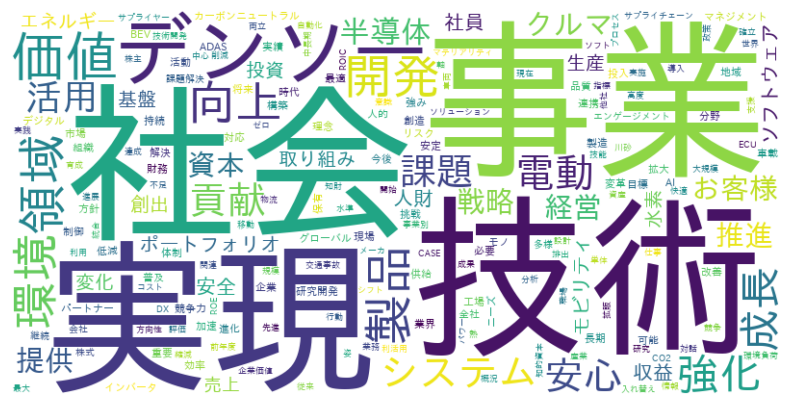

In [23]:
#抽出単語によるワードクラウド作成
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 日本語フォントのパスを指定
jp_font_path = '/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf'

# ワードクラウドのフォーマット指定
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path=jp_font_path)
# 単語とその頻度を辞書形式に変換
word_freq = {word: freq for word, freq in zip(count_df['単語'], count_df['件数'])}
# ワードクラウドの生成
wordcloud.generate_from_frequencies(word_freq)

# プロット
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 結果をpngファイルに出力
file_name_wordcloud=f'output/{company_code}_{company_name}_{date_time_string}_WordCloud.png'
wordcloud.to_file(file_name_wordcloud)

In [24]:
#tf-idf用に、ファイル名、企業名、トークンを出力

# データフレームの作成：pdfファイル名とトークンを格納
df_token = pd.DataFrame({"company_name": company_name, "doc_name": doc_name, "token": [Merged_Extracted_tokenized_list]})

file_name_token=f'output/{company_code}_{company_name}_{date_time_string}_Token.csv'
df_token.to_csv(file_name_token, encoding="utf_8_sig", index=False)

In [25]:
#以降、共起分析
#Extracted_page_text（抽出ページ単位のリスト）を、要素一つのリストに集約
Merged_Extracted_page_text = "\n\n".join(Extracted_page_text)
#print(Merged_Extracted_page_text)

#前処理したテキストを準備
Processed_Merged_Extracted_page_text = pre_tk(Merged_Extracted_page_text, eliminate_list)
#print(Processed_Merged_Extracted_page_text)

#集約・前処理したテキストを「。」で区切り、形態素解析（共起分析用）
sentences = [post_tk(tk.mecab_tokenizer(sentence)) for sentence in re.split("。", Processed_Merged_Extracted_page_text)]
#print(sentences)

In [26]:
#各文中の、形態素組み合わせを作る
sentences_combs = [list(itertools.combinations(sentence,2)) for sentence in sentences]
#print(sentences_combs[0])

#組み合わせた2つの形態素の並びをソート
words_combs = [[tuple(sorted(words)) for words in sentence] for sentence in sentences_combs]
#print(words_combs[0][:30])
target_combs = []
for words_comb in words_combs:
    target_combs.extend(words_comb)
ct = Counter(target_combs)
#print(ct)
df = pd.DataFrame([{"1番目" : i[0][0], "2番目": i[0][1], "count":i[1]} for i in ct.most_common()])

#ファイル出力
file_name_comb = f"output/{company_code}_{company_name}_{date_time_string}_Co_Occurrence.csv"
df.to_csv(file_name_comb, encoding="utf_8_sig", index=False)

In [27]:
#df.head(30)

In [33]:
#ネットワーク分析の下準備
import networkx as nx
from networkx.algorithms.community import girvan_newman
import network_plot_module as npm
import json

#########################################################
# 分析対象とする共起単語の組み合わせ数（ノード数）を指定
analyzed_links = 1000
limited_df = df.head(analyzed_links)
#########################################################
# DataFrameからネットワークを作成
G = nx.from_pandas_edgelist(limited_df, '1番目', '2番目', ['count'])


In [34]:
#print(G)
#limited_df.head(30)

In [35]:
# 各ノードの中心性を計算
try:
    degree_centrality = nx.degree_centrality(G)
except:
    degree_centrality = {node: '' for node in G.nodes()}
    
try:
    betweenness_centrality = nx.betweenness_centrality(G)
except:
    betweenness_centrality = {node: '' for node in G.nodes()}

try:
    closeness_centrality = nx.closeness_centrality(G)
except:
    closeness_centrality = {node: '' for node in G.nodes()}

try:
    eigenvector_centrality = nx.eigenvector_centrality(G)
except:
    eigenvector_centrality = {node: '' for node in G.nodes()}

try:
    katz_centrality = nx.katz_centrality(G)
except:
    katz_centrality = {node: '' for node in G.nodes()}

# Girvan-Newmanアルゴリズムでコミュニティに分割
comp = girvan_newman(G)
communities = tuple(sorted(c) for c in next(comp))

# 各ノードがどのコミュニティに属するかを記録
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# 中心性を新しいデータフレームに格納
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
#    'Katz Centrality': [katz_centrality[node] for node in G.nodes()],
    'Community': [community_map[node] for node in G.nodes()]  # コミュニティ情報を追加
    })
#print(centrality_df)

file_name_comb = f"output/{company_code}_{company_name}_{date_time_string}_Centrality_{analyzed_links}.csv"
centrality_df.to_csv(file_name_comb, encoding="utf_8_sig", index=False)

In [36]:
#ネットワーク図を描画、ファイル出力
got_net = npm.kyoki_word_network(limited_df)
#フィルタボタンを表示させる場合は、set_optionを無効にする必要あり
#got_net.show_buttons(filter_=['physics'])
got_net.set_options("""
const options = {
  "physics": {
    "forceAtlas2Based": {
      "centralGravity": 0.1,
      "springLength": 25,
      "springConstant": 0.1
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
}
""")
file_name_kyoki = f'output/{company_code}_{company_name}_{date_time_string}_kyoki_{analyzed_links}.html'
got_net.show(file_name_kyoki)

In [37]:
#処理した条件をテキストファイルに出力
file_name_condition=f'output/{company_code}_{company_name}_{date_time_string}_Condition.txt'

# ファイルを書き込みモードで開く
with open(file_name_condition, 'w') as file:
    # 各変数の値をテキストファイルに書き込む
    file.write(f"Company code = {company_code}\n")
    file.write(f"Company name = {company_name}\n")
    file.write(f"Industry = {industry}\n")
    file.write(f"File = {open_file}\n")
    file.write(f"Analysis area = {analysis_area}\n")
    file.write(f"Target Page = {man_page_index}\n")
    file.write(f"Analyzed Links = {analyzed_links}\n")
